In [128]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("hemsil2_datapoints_20102021.csv", parse_dates=True, index_col=0)
df = df[df.index < pd.Timestamp(year=2021, month=9, day=1)]
df = df.interpolate(method='linear')

In [129]:
df["err"] = df.apply(
    lambda row: row["hemsil2_inflow_corr"] - row["hbv_hemsil2_inflow_pred_24h"], axis=1
)

under_est = abs(df[df["err"] > 0]["err"])
over_est = abs(df[df["err"] < 0]["err"])

rolling_df = pd.DataFrame()
cols = (
    "flaevatn_ppt",
    "flaevatn_temp",
    "hbv_hemsil2_snow",
    "hbv_hemsil2_ground_water",
    "hbv_hemsil2_soil_water",
    "hbv_hemsil2_total_water",
    "storeskar_temp",
    "hbv_hemsil2_snow_cover"
)
HOURS_PER_WEEK = 24*7
for col in cols:
    rolling_df[col] = df[col].rolling(HOURS_PER_WEEK).mean()
    
# skip the dates where the rolling means not yet as been calculated
rolling_df = rolling_df[HOURS_PER_WEEK:]

Text(0, 0.5, 'Flow rate [Q/s]')

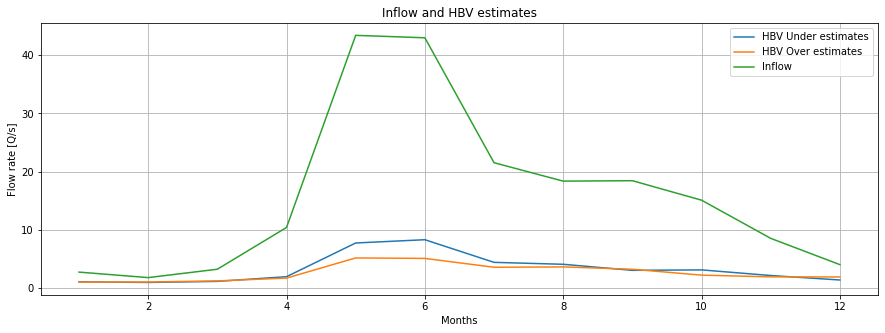

In [130]:
under_est.groupby(under_est.index.month).mean().plot(figsize=(15,5), label="HBV Under estimates")
over_est.groupby(over_est.index.month).mean().plot(label="HBV Over estimates")
df["hemsil2_inflow_corr"].groupby(df["hemsil2_inflow_corr"].index.month).mean().plot(label="Inflow")

plt.grid()
plt.title("Inflow and HBV estimates")
plt.legend()
plt.xlabel("Months")
plt.ylabel("Flow rate [Q/s]")

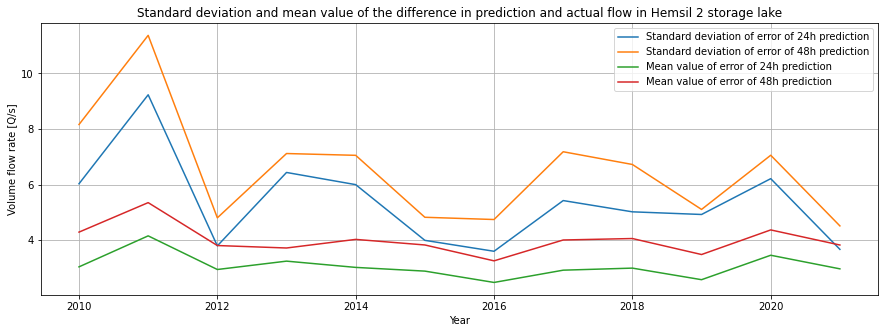

In [131]:
err24 = df["err"]
err48 = df.apply(
    lambda row: row["hemsil2_inflow_corr"] - row["hbv_hemsil2_inflow_pred_48h"], axis=1
)

err24y = abs(err24).groupby(err24.index.year)
err48y = abs(err48).groupby(err48.index.year)

err24y.std().plot(label="Standard deviation of error of 24h prediction", figsize=(15,5))
err48y.std().plot(label="Standard deviation of error of 48h prediction", figsize=(15,5))
err24y.mean().plot(label="Mean value of error of 24h prediction", figsize=(15,5))
err48y.mean().plot(label="Mean value of error of 48h prediction", figsize=(15,5))

plt.title("Standard deviation and mean value of the difference in prediction and actual flow in Hemsil 2 storage lake")
plt.xlabel("Year")
plt.savefig("bilde.jpg")
plt.ylabel("Volume flow rate [Q/s]")
plt.legend()
plt.grid()
plt.show()

In [132]:
corr_df = pd.DataFrame(
    [
        (
            rolling_df[col].corr(under_est.shift(-24)),
            rolling_df[col].corr(over_est.shift(-24)),
        )
        for col in cols
    ],
    columns=("under_est", "over_est"),
    index=cols,
)
corr_df

,under_est,over_est
flaevatn_ppt,0.205084,0.219489
flaevatn_temp,0.273881,0.294073
hbv_hemsil2_snow,-0.120004,-0.095786
hbv_hemsil2_ground_water,0.343944,0.341508
hbv_hemsil2_soil_water,0.004144,-0.002787
hbv_hemsil2_total_water,-0.080738,-0.054061
storeskar_temp,0.281756,0.309872
hbv_hemsil2_snow_cover,-0.168706,-0.149639


/var/folders/gg/s7x2wjw13c3gzk1nxp9850n80000gn/T/ipykernel_16739/4074412019.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["", *cols])
/var/folders/gg/s7x2wjw13c3gzk1nxp9850n80000gn/T/ipykernel_16739/4074412019.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["", "under_est", "over_est"])


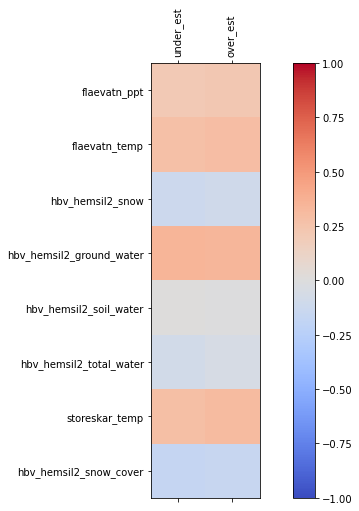

In [133]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
cax = ax.matshow(corr_df.to_numpy(), cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_yticklabels(["", *cols])
ax.set_xticklabels(["", "under_est", "over_est"])
plt.xticks(rotation=90)
plt.show()